In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import tifffile
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import seaborn as sns
from scipy.optimize import curve_fit

In [3]:
import popoff
from pop_off_functions import save_figure
from Session import SessionLite
from linear_model import PoolAcrossSessions, LinearModel, MultiSessionModel

user_paths_dict = popoff.loadpaths.loadpaths()
sys.path.append(user_paths_dict['vape_path'])
from utils.utils_funcs import d_prime

figure_path = '/home/jrowland/Documents/figures/s1s2_paper/0'

/home/jrowland/Documents/code/pop-off/popoff/popoff/loadpaths.py


In [4]:
from matplotlib import rcParams

params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}

plt.rc("axes.spines", top=False, right=False) # despine

COLORS = [
'#228E5E', # Hit green
'#DB3713', # Miss red
]

## MAKE THE FONT SIZE 20 or 21
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.size'] = 14


rcParams.update(params)



## Panels and b are rob's from fens figure

## Panel C

In [5]:
import os
import tifffile
import matplotlib.pyplot as plt

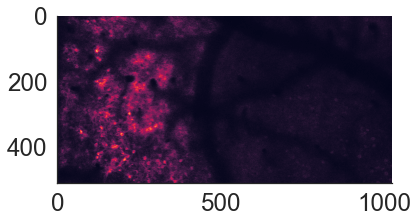

In [6]:
# I'm currently not using the image out of python, I did the central pixel selection and png saving in imagej.
# But this is the path to the correct image used in figure 1

tiff_path = os.path.expanduser('~/mnt/qnap/Data/2020-02-21/STA/2020-02-21_RL070_t-001/'
                               '2020-02-21_RL070_t-001_17Stims_STA_dF_MaxResponseImage.tif')

image = tifffile.imread(tiff_path)
# Select the central 512 lines
image = image[int(512 - (1024 / 4)):int(512 + (1024 / 4)), :]
plt.imshow(image)

## Panel d

In [7]:
msm = MultiSessionModel(remove_targets=False, subsample_sessions=False,
                         remove_toosoon = True)

long post time
long post time
long post time
long post time
long post time
long post time
long post time
ALERT SESSIONS NOT SUBSAMPLED
long post time
long post time
long post time
long post time
long post time
long post time
long post time


In [8]:
print(msm.plot_string('Both', is_plot=False))

Hello Adam
Remove targets is False.
Remove too soon is True
Here are the sessions in play:
['Mouse J064, run 10', 'Mouse J064, run 11', 'Mouse J064, run 14', 'Mouse RL070, run 28', 'Mouse RL070, run 29', 'Mouse J063, run 9', 'Mouse J065, run 11']
Cells in region Both are includedpre-frames spans -1.97 to -0.07 inclusive
post-frames spans 0.83 to  8.0 inclusive


In [9]:
lm = msm.linear_models[0]
print(lm.session)

Mouse J064, run 10


In [10]:
def baseline_subtraction(flu, lm):
    
    ''' Takes a cell averaged flu matrix [n_trials x time]
        and subtracts pre-stim activity of an individual trial 
        from every timepoint in that trial.
        '''
    baseline = np.mean(flu[:, lm.frames_map['pre']], 1)
    flu = np.subtract(flu.T, baseline).T
    return flu

In [11]:
def get_plot_trace(lm, targets=False, region='s1'):
    
    global COLOR_IDX
    
    if targets:
        mask = ~lm.session.is_target
    else:
        mask = lm.session.is_target
    
    flu = lm.flu[lm.region_map[region], :, :]
    mask = mask[lm.region_map[region], :, :]
    
    # Take out catch trials
    stim_idx = lm.session.photostim != 0
    flu = flu[:, stim_idx, :]
    mask = mask[:, stim_idx, :]
    
    # Fluoresence averaged across cells with (non)targets filtered
    flu = np.ma.array(flu, mask=mask).mean(0)
    flu = baseline_subtraction(flu, lm)
    
    # x axis in seconds aligned to stim
    x_axis = (np.arange(flu.shape[1]) - max(np.where(lm.pre)[0])) / 30
    label = 'Targets' if targets else f'Non Targets {region.upper()}'
    
    # Need to plot pre and post as two separate lines cos seaborn is uncooperative
    for idx_frames in [lm.pre, lm.post]:
        
        data = flu[:, idx_frames]
        
        df = pd.DataFrame(data).melt()
        df['time (seconds)'] = np.repeat(x_axis[idx_frames], data.shape[0])
        
        sns.lineplot(x='time (seconds)', y='value', data=df, color=sns.color_palette()[COLOR_IDX],
                    label=label)
        label = None
        
    plt.ylabel(r'$\Delta$F/F')
    legend = plt.legend(bbox_to_anchor=(1.4, 1.3))
    legend.get_frame().set_facecolor('none')
    COLOR_IDX += 1 

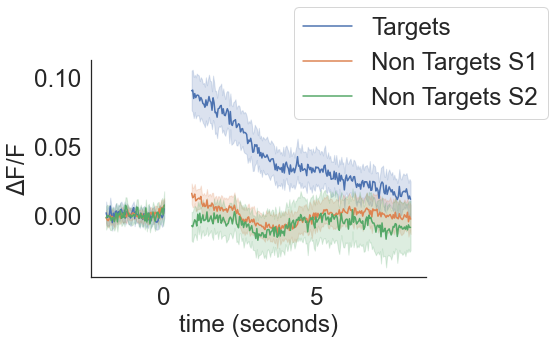

In [14]:
COLOR_IDX = 0  # Filthy global just to keep the pre and post color consistent
get_plot_trace(lm, targets=True, region='s1')
get_plot_trace(lm, targets=False, region='s1')
get_plot_trace(lm, targets=False, region='s2')

save_figure('Figure1PanelD', figure_path)

## Panels E and F are from fens poster

## Panel G

In [15]:
def get_subset_dprime(session):
    
    assert session.trial_subsets.shape == session.outcome.shape
    
    fp_rate = sum(session.outcome=='fp') / (sum(session.outcome=='fp') + sum(session.outcome=='cr'))
    subset_dprimes = []
    for subset in [[5, 10], [20, 30], [40, 50], [150]]:
        idx = np.isin(session.trial_subsets, subset)
        outcome = session.outcome[idx]
        hit_rate = sum(outcome=='hit') / (sum(outcome=='hit') + sum(outcome=='miss'))
        subset_dprimes.append(d_prime(hit_rate, fp_rate))
    
    return subset_dprimes

In [16]:
subset_dprimes = [get_subset_dprime(lm.session) for lm in msm.linear_models]
subset_dprimes = np.array(subset_dprimes)

In [17]:
# psychometric function
def pf(x, alpha, beta):
    return 1. / (1 + np.exp( -(x-alpha)/beta ))

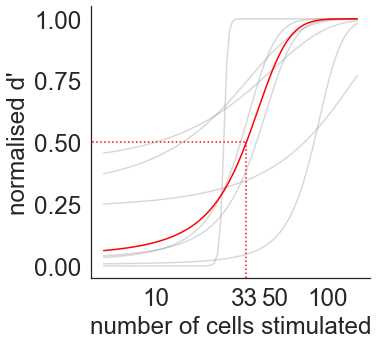

In [30]:
np.seterr(divide='ignore')  # Ugly division by 0 error
plt.figure(figsize=(5,5))

x_axis = [7.5, 25, 45, 150]
all_dp = []
for dp in subset_dprimes:
    dp = dp / max(dp)
    all_dp.append(dp)
    popt, pcov = curve_fit(pf, x_axis, dp, method='dogbox', p0=[50, 200])
    plt.plot(np.arange(5,max(x_axis)), pf(np.arange(5,max(x_axis)), *popt), color='grey', alpha=0.3)
    plt.xscale('log')
    
y = np.concatenate(all_dp)
x = np.tile(x_axis, subset_dprimes.shape[0])
popt, pcov = curve_fit(pf, x, y, method='dogbox', p0=[50, 200])
plt.plot(np.arange(5,max(x_axis)), pf(np.arange(5,max(x_axis)), *popt), color='red')

plt.xscale('log')
plt.ylabel('normalised d\'')
plt.xlabel('number of cells stimulated', fontname='Arial')

ticks = [10, int(popt[0]), 50, 100]
plt.axvline(x=popt[0], ymax=0.5, color='red', ls=':')
plt.hlines(y=0.5, xmin=0, xmax=popt[0], color='red', ls=':')

_ = plt.xticks(ticks, ticks)
save_figure('Figure1PanelG', figure_path)

## Raw data of the above figure

Text(0, 0.5, "d'")

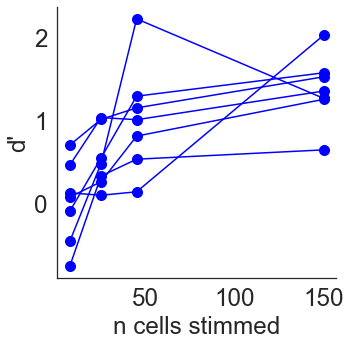

In [39]:
plt.figure(figsize=(5,5))
x_axis = [7.5, 25, 45, 150]

for dp in subset_dprimes:
    plt.plot(x_axis, dp, marker='o', color='blue', markersize=10)
plt.xlabel('n cells stimmed')
plt.ylabel('d\'')

## Hex color codes for the seaborn palette

In [27]:
pal = sns.color_palette()
print(pal.as_hex())

['#4c72b0', '#dd8452', '#55a868', '#c44e52', '#8172b3', '#937860', '#da8bc3', '#8c8c8c', '#ccb974', '#64b5cd']


In [28]:
pal

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]